In [1]:
import numpy as np
import pandas as pd
import glob
import os
from tqdm.notebook import tqdm
tqdm.pandas()

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.naive_bayes import GaussianNB

import re
import emoji

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess

from preprocessor import Preprocessor

In [2]:
df = pd.read_csv('./dataset/Tweets/tweets-sentiment-500k.csv', lineterminator='\n')

In [3]:
def get_df_info(df):
    print('Dataframe shape: ', df.shape)
    print('-----'*20)
    print('Dataframe info: ')
    print(df.info())
    print('-----'*20)
    print('Dataframe null values count:')
    print(df.isna().sum())
    print('-----'*20)
    print('Dataframe duplicates count:')
    print(df.duplicated().sum())
    print('-----'*20)
    print('Dataframe sample: ')
    display(df.sample(10))

In [4]:
get_df_info(df)

Dataframe shape:  (532142, 6)
----------------------------------------------------------------------------------------------------
Dataframe info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532142 entries, 0 to 532141
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   index      532142 non-null  int64  
 1   date       532142 non-null  object 
 2   tweets     532142 non-null  object 
 3   bearish    532142 non-null  float64
 4   bullish    532142 non-null  float64
 5   sentiment  532142 non-null  object 
dtypes: float64(2), int64(1), object(3)
memory usage: 24.4+ MB
None
----------------------------------------------------------------------------------------------------
Dataframe null values count:
index        0
date         0
tweets       0
bearish      0
bullish      0
sentiment    0
dtype: int64
----------------------------------------------------------------------------------------------------
Dataframe du

,index,date,tweets,bearish,bullish,sentiment
114791,809237,2020-07-09 21:17:52+00:00,@clifftharippa I believe it will run till July...,0.001432,0.998568,bullish
274747,13151,2020-04-09 01:38:11+00:00,RT @PeterLBrandt: $SPX $ES_F \nFollowing this ...,0.986662,0.013338,bearish
331024,195827,2020-04-25 13:12:48+00:00,How Your Marital Status Will Affect Your Stimu...,0.509185,0.490815,bearish
242624,244388,2020-04-29 14:27:00+00:00,Every trader has strengths and weakness...\n.\...,0.062353,0.937647,bullish
109573,713729,2020-06-30 02:17:48+00:00,The #sp500 and #stockmarket is still very bull...,0.001388,0.998612,bullish
258352,263428,2020-05-04 15:18:44+00:00,$SNE Sony sensors\nWho needs cameras? Telepres...,0.001395,0.998605,bullish
332475,201248,2020-04-26 18:41:10+00:00,"Short #axisbank target 380, 350 \nStop loss 41...",0.997530,0.002470,bearish
101983,529813,2020-06-16 18:21:27+00:00,Spoke with a member this morning who had set o...,0.026722,0.973278,bullish
370567,340340,2020-05-28 07:15:49+00:00,@FirstSquawk First Squawk\n$SPX $NDX ALZHEIMER...,0.869117,0.130883,bearish
338172,222450,2020-04-28 19:56:38+00:00,$ES_F $SPY $VXX $NYSE #SP500 #stockmarket #mar...,0.975461,0.024539,bearish


In [5]:
df.groupby('sentiment')['tweets'].count()

sentiment
bearish    262142
bullish    270000
Name: tweets, dtype: int64

### Model building and training

In [6]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ayeesha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# from nltk.stem import WordNetLemmatizer
# import re
# import emoji
# from sklearn.feature_extraction.text import CountVectorizer

# class Preprocessor:
#     def __init__(
#         self, 
#         stopwords=stopwords.words('english'), 
#         vectorizer = CountVectorizer(max_features=30000, ngram_range=(1,3))
#     ):
#         self.stopwords = stopwords
#         self.vectorizer = vectorizer
#         self.vectorizer_fitted = False
#         self.wnl = WordNetLemmatizer()
#         self.usernam_pattern = re.compile(r'(\@)(\S+)')
#         self.twitter_handle_pattern = re.compile(r'(\#)(\S+)')
    
#     def clean_tweet(self, texts):
#         print('Cleaning...')
#         cleaned_texts = []
#         for text in texts:
#             # Replace @usernames with the text mention_
#             text = re.sub(self.usernam_pattern, r'mention_\2', text)
#             # Replace #hashtags with the text hashtag_
#             text = re.sub(self.twitter_handle_pattern, r'hashtag_\2', text)
#             # remove URLs
#             text = re.sub(r'https?://\S+', "", text)
#             text = re.sub(r'www.\S+', "", text)
#             # remove $cashtags
#             text = re.sub(r'(\$)([A-Za-z]+)', r'cashtag_\2', text)
#             # deemojize
#             text = emoji.demojize(text, delimiters=("", " "))
#             # remove punctuations
#             # text = re.sub(r'[^\w\s]', '', text)
#             # remove numbers
#             # text = re.sub(r'[0-9]', ' ', text)
#             # remove extra spaces
#             text = re.sub(r' +', ' ', text)
#             text = text.strip()
#             cleaned_texts.append(text)

#         return cleaned_texts
    
#     def tokenize(self, texts):
#         print('Tokenizing...')
#         return [word_tokenize(text) for text in texts]

#     def lemmatize(self, texts):
#         tokens_list = self.tokenize(texts)
#         print('Lemmatizing...')
#         return [' '.join(self.negation_handler(text)) for text in tokens_list]
    
#     # https://github.com/UtkarshRedd/Negation_handling/blob/main/NegationHandling.py
#     def negation_handler(self, sentence):
#         temp = int(0)
#         for i in range(len(sentence)):
#             if sentence[i-1] in ['not',"n't"]:
#                 antonyms = []
#                 for syn in wordnet.synsets(sentence[i]):
#                     syns = wordnet.synsets(sentence[i])
#                     w1 = syns[0].name()
#                     temp = 0
#                     for l in syn.lemmas():
#                         if l.antonyms():
#                             antonyms.append(l.antonyms()[0].name())
#                     max_dissimilarity = 0
#                     for ant in antonyms:
#                         syns = wordnet.synsets(ant)
#                         w2 = syns[0].name()
#                         syns = wordnet.synsets(sentence[i])
#                         w1 = syns[0].name()
#                         word1 = wordnet.synset(w1)
#                         word2 = wordnet.synset(w2)
#                         if isinstance(word1.wup_similarity(word2), float) or isinstance(word1.wup_similarity(word2), int):
#                             temp = 1 - word1.wup_similarity(word2)
#                         if temp>max_dissimilarity:
#                             max_dissimilarity = temp
#                             antonym_max = ant
#                             sentence[i] = antonym_max
#                             sentence[i-1] = ''
#         while '' in sentence:
#             sentence.remove('')
#         return sentence

#     def fit(self, X):
#         X = X.copy()
#         X = self.clean_tweet(X)                     # clean tweets
#         X = self.lemmatize(X)                       # lemmatize
#         print('Fitting vectorizer...')
#         self.vectorizer.fit(X)
#         print('Done')

#     def transform(self, X):
#         X = X.copy()
#         # print('Removing Nans...')
#         # X = X[~X.isnull()]                          # delete nans
#         # X = X[~X.duplicated()]                      # delete duplicates
        
#         # X = self.remove_stopwords(X)                 # remove stopwords
#         X = self.clean_tweet(X)
#         X = self.lemmatize(X)                        # lemmatize

#         print('Vectorizing...')
#         X = self.vectorizer.transform(X)             # vectorize
#         print('Done')
#         return X

In [8]:
# Reusable model function
def fit_train_predict_model(X_train, y_train, X_test, y_test):
    models = [
        LogisticRegression(C = 2, solver='liblinear', max_iter=1000),
        #RandomForestClassifier(),
        # DecisionTreeClassifier(),
        MultinomialNB()
        # SGDClassifier(max_iter=100),
        # LinearSVC(C = 2, max_iter=500)
    ]
    for model in models:
        model.fit(X_train, y_train)
        y_pred_test = model.predict(X_test)
        print('======='*10)
        print(type(model).__name__)
        print('======='*10)
        print(classification_report(y_test, y_pred_test))
        sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True)
        plt.show()
    
    return models

### Train test split

In [9]:
(X_train, X_test, y_train, y_test) = train_test_split(df['tweets'], df['sentiment'], test_size=0.2)

### Preprocess using CountVectorizer (Bag of words)

In [10]:
X_cv_train = X_train.copy()
X_cv_test = X_test.copy()

In [11]:
cv_preprocessor = Preprocessor(CountVectorizer(ngram_range=(1,3))) # Default vectorizer is the CountVectorizer
cv_preprocessor.fit(X_cv_train)
X_cv_train = cv_preprocessor.transform(X_cv_train)
X_cv_test = cv_preprocessor.transform(X_cv_test)

Cleaning...
Tokenizing...
Negation handling...
Fitting vectorizer...
Done
Cleaning...
Tokenizing...
Negation handling...
Vectorizing...
Done
Cleaning...
Tokenizing...
Negation handling...
Vectorizing...
Done


In [12]:
print(X_cv_train.shape)
print(y_train.shape)

(425713, 30000)
(425713,)


LogisticRegression
              precision    recall  f1-score   support

     bearish       0.84      0.85      0.84     52362
     bullish       0.85      0.84      0.85     54067

    accuracy                           0.84    106429
   macro avg       0.84      0.84      0.84    106429
weighted avg       0.84      0.84      0.84    106429



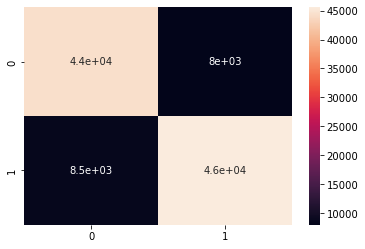

MultinomialNB
              precision    recall  f1-score   support

     bearish       0.78      0.76      0.77     52362
     bullish       0.78      0.79      0.78     54067

    accuracy                           0.78    106429
   macro avg       0.78      0.78      0.78    106429
weighted avg       0.78      0.78      0.78    106429



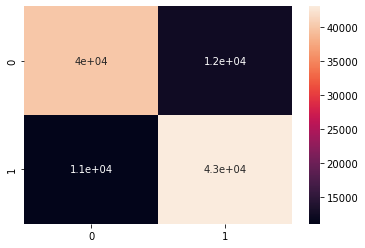

In [13]:
cv_models = fit_train_predict_model(X_cv_train, y_train, X_cv_test, y_test)

In [14]:
import pickle
pickle.dump(cv_preprocessor, open('cv_preprocessor.pkl', 'wb'))
pickle.dump(cv_models[0], open('cv_log_reg_model.pkl', 'wb'))

### Vectorize the text feature using Tfidf Vectorizer

In [15]:
X_tfidf_train = X_train.copy()
X_tfidf_test = X_test.copy()

In [16]:
tfidf_preprocessor = Preprocessor(vectorizer=TfidfVectorizer(lowercase=False, max_features=30000, min_df=10, ngram_range=(1, 3)))

tfidf_preprocessor.fit(X_tfidf_train)
X_tfidf_train = tfidf_preprocessor.transform(X_tfidf_train)
X_tfidf_test = tfidf_preprocessor.transform(X_tfidf_test)


Cleaning...
Tokenizing...
Negation handling...
Fitting vectorizer...
Done
Cleaning...
Tokenizing...
Negation handling...
Vectorizing...
Done
Cleaning...
Tokenizing...
Negation handling...
Vectorizing...
Done


In [17]:
print(X_tfidf_train.shape)
print(y_train.shape)

(425713, 30000)
(425713,)


LogisticRegression
              precision    recall  f1-score   support

     bearish       0.83      0.85      0.84     52362
     bullish       0.85      0.84      0.84     54067

    accuracy                           0.84    106429
   macro avg       0.84      0.84      0.84    106429
weighted avg       0.84      0.84      0.84    106429



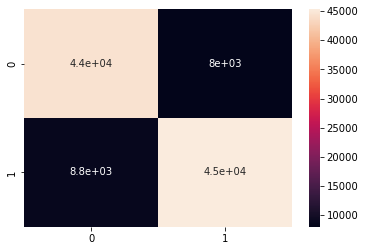

MultinomialNB
              precision    recall  f1-score   support

     bearish       0.77      0.79      0.78     52362
     bullish       0.79      0.77      0.78     54067

    accuracy                           0.78    106429
   macro avg       0.78      0.78      0.78    106429
weighted avg       0.78      0.78      0.78    106429



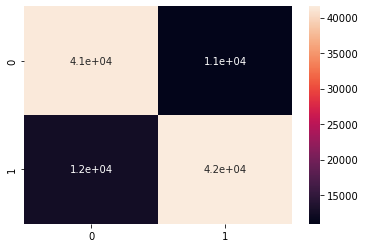

In [18]:
tfidf_models = fit_train_predict_model(X_tfidf_train, y_train, X_tfidf_test, y_test)

### Word2Vec vectorization

In [19]:
# class Word2Vectorizer():
#     def __init__(self):
#         self.model = None
#         self.vector_size = 1000

#     def fit(self, X):
#         tweet_list = [word_tokenize(tweet) for tweet in X]
#         model = Word2Vec(tweet_list, min_count=2, window = 3, sg = 1, workers = 8, max_vocab_size = None, vector_size=self.vector_size)
#         self.model = model
#         print(len(model.wv))
    
#     #Build word vector for training set by using the average value of all word vectors in the tweet, then scale
#     def __buildWordVector(self, text, size):
#         vec = np.zeros(size)
#         count = 0.
#         for word in text:
#             try:
#                 vec += self.model.wv[word]
#                 count += 1.
#             except KeyError:
#                 continue
#         if count != 0:
#             vec /= count
#         return vec

#     def transform(self, X):
#         # self.model = gensim.models.Word2Vec.load('tweets.embedding')
#         tweet_list = [word_tokenize(tweet) for tweet in X]
#         return [self.__buildWordVector(tweet, self.vector_size) for tweet in tweet_list]
         

In [20]:
# X_w2v_train = X_train.copy()
# X_w2v_test = X_test.copy()

In [21]:
# w2vectorizer = Word2Vectorizer()

# w2v_preprocessor = Preprocessor(vectorizer=w2vectorizer) # Default vectorizer is the CountVectorizer

# w2v_preprocessor.fit(df['tweets'])
# X_w2v_train = w2v_preprocessor.transform(X_w2v_train)
# X_w2v_test = w2v_preprocessor.transform(X_w2v_test)

In [22]:
# w2v_models = fit_train_predict_model(X_w2v_train, y_train, X_w2v_test, y_test)

### Doc2Vec

In [23]:
# class Doc2Vectorizer():
#     def __init__(self):
#         self.model = None
#         self.vector_size = 1000

#     def fit(self, X):
#         documents = [TaggedDocument(simple_preprocess(doc), [i]) for i, doc in enumerate(X)]
#         self.model = Doc2Vec(documents, vector_size = self.vector_size, min_count=2, window = 3, dm = 0, workers = 8)

#     def transform(self, X):
#         tweet_list = [simple_preprocess(tweet) for tweet in X]
#         return [self.model.infer_vector(tweet) for tweet in tweet_list]
        

In [24]:
# X_d2v_train = X_train.copy()
# X_d2v_test = X_test.copy()

In [25]:
# d2vectorizer = Doc2Vectorizer()

# d2v_preprocessor = Preprocessor(vectorizer=d2vectorizer) # Default vectorizer is the CountVectorizer

# d2v_preprocessor.fit(X_d2v_train)
# X_d2v_train = d2v_preprocessor.transform(X_d2v_train)
# X_d2v_test = d2v_preprocessor.transform(X_d2v_test)

In [26]:
# d2v_models = fit_train_predict_model(X_d2v_train, y_train, X_d2v_test, y_test)